In [81]:
# !pip install ultralytics onnxruntime-gpu onnxruntime opencv-python matplotlib

In [82]:
# # Colab cell
# !wget -nc -O yolov8n.pt https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8n.pt

In [1]:
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import numpy as np
import onnxruntime as ort
import time

In [84]:
img_path = '/home/atin/vutl/person.jpg'

In [2]:
print('ort.get_available_providers():', ort.get_available_providers())

ort.get_available_providers(): ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [85]:
model = YOLO("yolov8n.pt")
model.export(format="onnx", imgsz=640, simplify=True)
# File xuất ra: yolov8n.onnx

Ultralytics 8.3.227 🚀 Python-3.13.5 torch-2.9.0+cu128 CPU (Intel Core i9-10980XE 3.00GHz)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success ✅ 0.9s, saved as 'yolov8n.onnx' (12.3 MB)

Export complete (1.1s)
Results saved to /home/atin/vutl/ONNX
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8n.onnx'

In [86]:
COCO_CLASSES = [
    "person","bicycle","car","motorcycle","airplane","bus","train","truck","boat","traffic light","fire hydrant",
    "stop sign","parking meter","bench","bird","cat","dog","horse","sheep","cow","elephant","bear","zebra","giraffe",
    "backpack","umbrella","handbag","tie","suitcase","frisbee","skis","snowboard","sports ball","kite","baseball bat",
    "baseball glove","skateboard","surfboard","tennis racket","bottle","wine glass","cup","fork","knife","spoon",
    "bowl","banana","apple","sandwich","orange","broccoli","carrot","hot dog","pizza","donut","cake","chair","couch",
    "potted plant","bed","dining table","toilet","tv","laptop","mouse","remote","keyboard","cell phone","microwave",
    "oven","toaster","sink","refrigerator","book","clock","vase","scissors","teddy bear","hair drier","toothbrush"
]

In [87]:
def filter_Detections(results, thresh=0.5):
    det_list = []
    for detection in results:
        class_id = detection[4:].argmax()
        confidence_score = detection[4:].max()
        if confidence_score > thresh:
            det_list.append(np.append(detection[:4], [class_id, confidence_score]))
    return np.array(det_list)

def rescale_back(detections, img_w, img_h):
    cx, cy, w, h = detections[:,0], detections[:,1], detections[:,2], detections[:,3]
    class_id, confidence = detections[:,4], detections[:,5]
    x1 = (cx - w/2) / 640 * img_w
    y1 = (cy - h/2) / 640 * img_h
    x2 = (cx + w/2) / 640 * img_w
    y2 = (cy + h/2) / 640 * img_h
    boxes = np.column_stack((x1, y1, x2, y2, class_id, confidence))
    return boxes

def run_nms(boxes, confidences, iou_thresh=0.5):
    nms_indices = cv2.dnn.NMSBoxes(
        bboxes=[list(map(int, box[:4])) for box in boxes],
        scores=confidences,
        score_threshold=0.5,
        nms_threshold=iou_thresh)
    return nms_indices

In [88]:
def onnx_infer(model_path, img_path, provider='CPUExecutionProvider'):
    img = cv2.imread(img_path)
    orig_h, orig_w = img.shape[:2]
    img_resized = cv2.resize(img, (640, 640))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_input = img_rgb.transpose(2, 0, 1).reshape(1, 3, 640, 640)
    img_input = img_input.astype(np.float32) / 255.0

    ort_session = ort.InferenceSession(model_path, providers=[provider])
    start = time.time()
    outputs = ort_session.run(None, {'images': img_input})
    end = time.time()

    results = outputs[0]
    results = np.squeeze(results).transpose()
    detections = filter_Detections(results, thresh=0.5)
    boxes = rescale_back(detections, orig_w, orig_h)
    confidences_list = boxes[:,5].tolist() if len(boxes) > 0 else []
    nms_indices = run_nms(boxes, confidences_list, iou_thresh=0.5) if len(boxes) > 0 else []
    duration = end - start

    img_draw = img.copy()
    if len(boxes) > 0 and len(nms_indices) > 0:
        for b in boxes[nms_indices.flatten()]:
            x1, y1, x2, y2, cls_id, conf = b
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cls_id = int(cls_id)
            conf = f"{conf:.2f}"
            label = f"{COCO_CLASSES[cls_id]} {conf}"
            cv2.rectangle(img_draw, (x1, y1), (x2, y2), (255,0,0), 2)
            cv2.putText(img_draw, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    return img_draw, duration

In [89]:
def ultralytics_infer(model_path, img_path):
    start = time.time()
    yolo_model = YOLO(model_path)
    results = yolo_model(img_path, conf=0.5)
    end = time.time()
    duration = end - start

    results[0].save(filename='yolo_output.jpg')
    img_draw = cv2.cvtColor(cv2.imread('yolo_output.jpg'), cv2.COLOR_BGR2RGB)
    return img_draw, duration

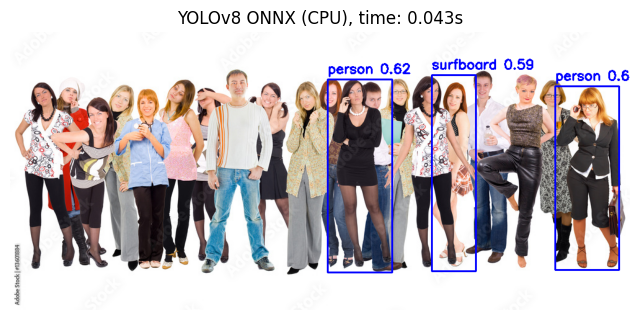

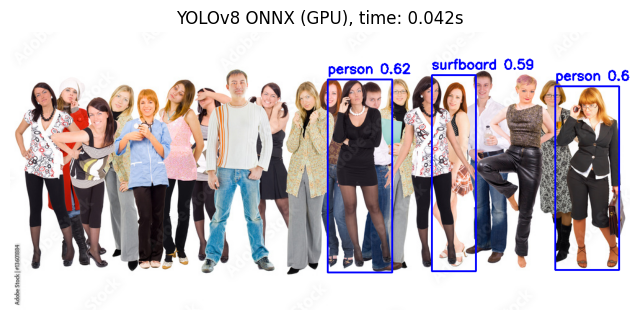


image 1/1 /home/atin/vutl/person.jpg: 288x640 11 persons, 29.3ms
Speed: 5.5ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)


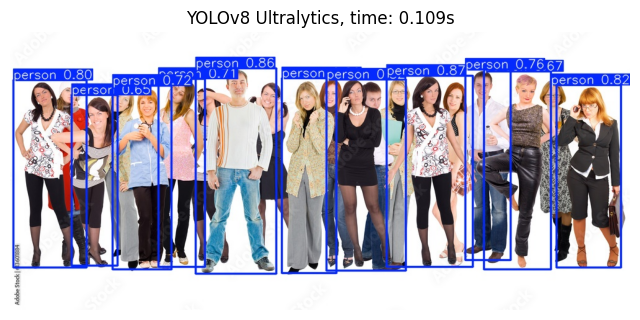

YOLO ONNX (CPU): 0.0428s
YOLO ONNX (GPU): 0.0423s
YOLO Ultralytics: 0.1094s


In [90]:
# ONNX CPU
img_onnx_cpu, time_onnx_cpu = onnx_infer('yolov8n.onnx', img_path, provider='CPUExecutionProvider')
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img_onnx_cpu, cv2.COLOR_BGR2RGB))
plt.title(f'YOLOv8 ONNX (CPU), time: {time_onnx_cpu:.3f}s')
plt.axis('off')
plt.show()

# ONNX GPU
img_onnx_gpu, time_onnx_gpu = onnx_infer('yolov8n.onnx', img_path, provider='CUDAExecutionProvider')
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img_onnx_gpu, cv2.COLOR_BGR2RGB))
plt.title(f'YOLOv8 ONNX (GPU), time: {time_onnx_gpu:.3f}s')
plt.axis('off')
plt.show()

# YOLOv8 Ultralytics (PyTorch, thường tự động dùng GPU nếu có)
img_yolo, time_yolo = ultralytics_infer('yolov8n.pt', img_path)
plt.figure(figsize=(8,6))
plt.imshow(img_yolo)
plt.title(f'YOLOv8 Ultralytics, time: {time_yolo:.3f}s')
plt.axis('off')
plt.show()

# So sánh thời gian
print(f"YOLO ONNX (CPU): {time_onnx_cpu:.4f}s")
print(f"YOLO ONNX (GPU): {time_onnx_gpu:.4f}s")
print(f"YOLO Ultralytics: {time_yolo:.4f}s")